In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from tqdm import tqdm
import os
import sys
import math

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from collections import defaultdict


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
aa_inds = pd.read_csv('data/aa_inds.csv')
# b_blos = pd.read_csv('data/olga_big.csv', low_memory=False)
# b_blos.head()

In [3]:
from torch.nn.utils import spectral_norm


In [4]:
import torch.nn.functional as F


In [5]:
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(parent_dir)
sys.path.append(os.path.abspath(os.path.join(parent_dir, '..')))

In [6]:
sys.path.append(os.path.join('/home/akabalina', 'OLGA/olga'))
# sys.path

In [7]:
parent_dir

'/home/akabalina/nlp_tcr_predictor/tcremp_embs'

In [8]:
import olga.load_model as load_model
import olga.generation_probability as pgen
params_file_name = '/home/akabalina/OLGA/olga/default_models/human_T_beta/model_params.txt'
marginals_file_name = '/home/akabalina/OLGA/olga/default_models/human_T_beta/model_marginals.txt'
V_anchor_pos_file ='/home/akabalina/OLGA/olga/default_models/human_T_beta/V_gene_CDR3_anchors.csv'
J_anchor_pos_file = '/home/akabalina/OLGA/olga/default_models/human_T_beta/J_gene_CDR3_anchors.csv'
genomic_data = load_model.GenomicDataVDJ()
genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)

generative_model = load_model.GenerativeModelVDJ()
generative_model.load_and_process_igor_model(marginals_file_name)

pgen_model = pgen.GenerationProbabilityVDJ(generative_model, genomic_data)

In [9]:
def pgen_log(pgen_val):
    if pgen_val < 1e-20:
        pgen_val += 1e-20
    return round(math.log10(pgen_val), 5)

def encode_seq(seq):
    mtr = np.zeros((10, len(seq), 20))
    for factor in range(10):
        for aa_i in range(len(seq)):
            mtr[factor, aa_i, list(aa_inds[f'f{factor+1}']).index(seq[aa_i])] = 1
        
    return mtr

# Utils functions for GPU usage of neural networks
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
class SoftExponential(nn.Module):
    def __init__(self, alpha=-0.5, beta=1000.0):
        super(SoftExponential, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        if self.alpha.item() < 0:
            return -1.0 * self.beta / self.alpha * (torch.exp(-self.alpha * x) - 1)
        elif self.alpha.item() == 0:
            return x * self.beta
        else:
            return 1.0 * self.beta / self.alpha * (torch.exp(self.alpha * x) - 1)

def decode_seq(pred, aa_inds=aa_inds, seq_length=15):
    pred = pred.argmax(dim=2)
    pred_seqs = []
    
    for i in range(pred.shape[0]):
        curr_code = aa_inds[f'f{i+1}']
        curr_seq = pred[i].tolist()
        # print('')
        dec_seq = []
        for j in range(seq_length):
            # print(curr_seq[j])
            # print('')

            dec_seq.append(curr_code.loc[curr_seq[j]])
        dec_seq = ''.join(dec_seq)
        pgen = pgen_model.compute_aa_CDR3_pgen(dec_seq)
        pred_seqs.append((''.join(dec_seq), pgen_log(pgen)))
    
    pred_seqs.sort(key = lambda x: x[1], reverse=True)
    # decoded_seq = ''.join(reverse_aa[pred])
    # pgen = pgen_model.compute_aa_CDR3_pgen(decoded_seq)
    return pred_seqs[0]



In [10]:
batch_size = 64
latent_size = 128

In [11]:
discriminator = nn.Sequential(
    spectral_norm(nn.Conv2d(10, 32, kernel_size=3, stride=1, padding=1, bias=False)),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=False)),
    
    nn.Flatten(),
    nn.Linear(15, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    SoftExponential())

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.Dropout(0.3),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.Dropout(0.3),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.Dropout(0.3),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 10, kernel_size=(4, 5), stride=(1, 1), padding=(10, 8), bias=False),
    nn.Tanh()
)

In [18]:
# # latent = torch.randn(100, latent_size, 1, 1, device=device)
# latent = torch.rand(batch_size, latent_size, 1, 1, device=device)
#     # pgen = torch.empty(num_samples, 1, device=device).uniform_(-30, -6)
# samples = generator(latent)
# with torch.no_grad():
#     seqs = decode_seq(samples, return_all=True)
#     sequences = list(map(lambda x: x[0], seqs))

#     unique_seqs = set(sequences)
        
#     diversity = len(unique_seqs) / len(sequences)


In [19]:
# f'{diversity:.2%}'

In [7]:
import pickle

In [8]:
with open('logs/gan/20250522-040142/history.pkl', 'rb') as f:
    history = pickle.load(f)

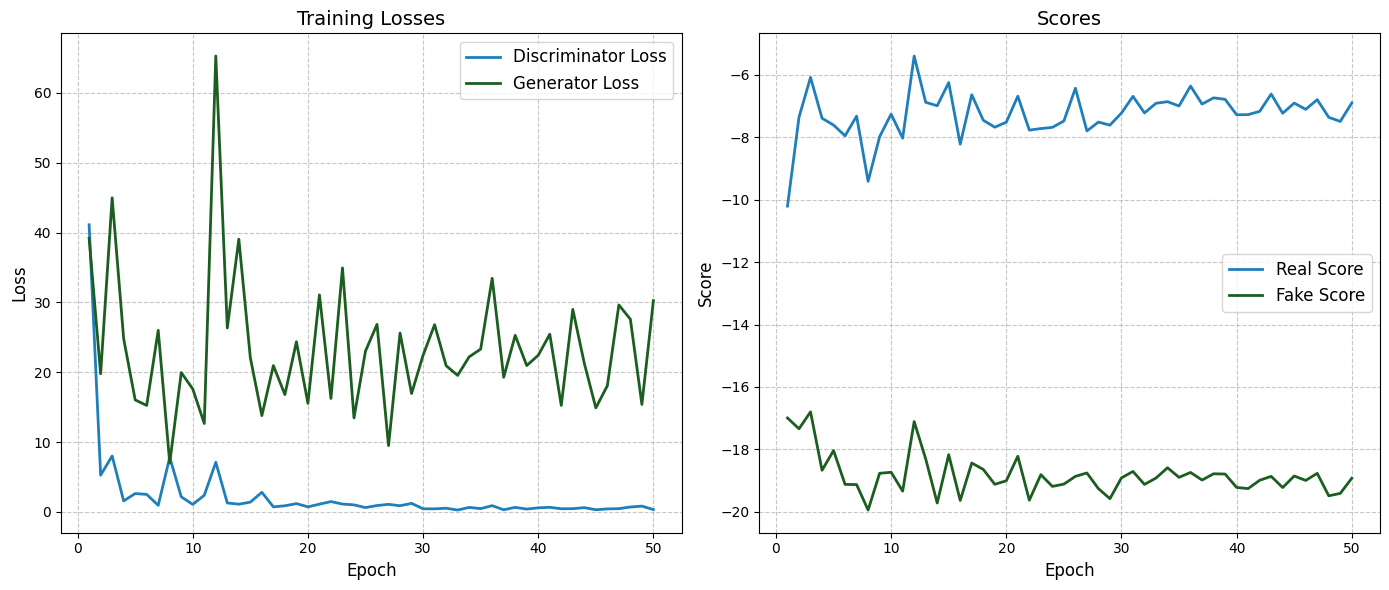

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    # Подготовка данных
    epochs = np.arange(1, len(history['losses_d']) + 1)
    
    # Создание фигуры с двумя subplots
    plt.figure(figsize=(14, 6))
    
    # График 1: Функции потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['losses_d'], color='#1e7fba', label='Discriminator Loss', linewidth=2)
    plt.plot(epochs, history['losses_g'], color='#1b5e20', label='Generator Loss', linewidth=2)
    # plt.plot(epochs, history['diversity'], label='diversity', linewidth=2)
    
    plt.title('Training Losses', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # График 2: Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['real_scores'], color='#1e7fba', label='Real Score', linewidth=2)
    plt.plot(epochs, history['fake_scores'], color='#1b5e20', label='Fake Score', linewidth=2)
    
    plt.title('Scores', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    
    plt.tight_layout()
    # plt.savefig('models/learning.png')
    plt.show()


plot_training_history(history)

In [12]:
len(all_p[0])

32

In [35]:
history.keys()

dict_keys(['d_loss', 'g_loss', 'real_score', 'fake_score', 'diversity', 'all_pgen'])

In [24]:
checkpoint = torch.load('logs/gan/checkpoints2/epoch_22.pth')

generator.load_state_dict(checkpoint['generator'])
discriminator.load_state_dict(checkpoint['discriminator'])
# opt_g.load_state_dict(checkpoint['opt_g'])
# opt_d.load_state_dict(checkpoint['opt_d'])


<All keys matched successfully>

In [25]:
# discriminator = Discriminator()
discriminator = to_device(discriminator, device)

In [26]:
# generator = Generator(latent_size=latent_size)
generator = to_device(generator, device)

In [27]:
latent = torch.rand(30, latent_size, 1, 1, device=device) * 2 - 1
fake_images = generator(latent)


In [31]:
seqs_decoded = []
pgenes = []
for seq in fake_images:
    seq_curr, pgen = decode_seq(seq)
    seqs_decoded.append(seq_curr)
    pgenes.append(pgen)

In [32]:
seqs_decoded

['CATDALRQSNQPQHF',
 'CASSLFFGIGQTQYF',
 'CASSLFFGIGQTQYF',
 'CASEARDDGNQPQHF',
 'CASSLFFGLGQTQYF',
 'CATTALRQSNQPQHF',
 'CASSLLRQSGDTQYF',
 'CASSLGRQSNQPQHF',
 'CATSLFFGEGNTQYF',
 'CASSLGVSGQNTQYF',
 'CASSLTGWSNQPQHF',
 'CASSQFFGIGQTQYF',
 'CASSLGGWSGDTQYF',
 'CASSLFFGIGQTQYF',
 'CASSWGHYPNQPQHF',
 'CASSSFHYRNRPQYF',
 'CASSLFFGIGQTQYF',
 'CASSLERGGGQTQYF',
 'CASSLFFGIGQTQYF',
 'CASSLQEGIGQTQYF',
 'CASSLGGQSGQPQHF',
 'CASSLFEGIGQTQYF',
 'CATTALRQSGDTQYF',
 'CASENRIDGNQPQHF',
 'CASSLFFGLGNTQYF',
 'CASSLGGWSGDTQYF',
 'CASSLGRWSTDTQYF',
 'CASSQFFGIGQTQYF',
 'CASSLFFGIGQTQYF',
 'CASSLLRGSNQPQHF']

In [30]:
pgenes

[-11.91692,
 -12.27591,
 -12.27591,
 -11.12261,
 -11.43572,
 -11.00052,
 -9.79148,
 -7.30052,
 -14.08104,
 -10.72148,
 -7.53149,
 -13.04273,
 -9.56798,
 -12.27591,
 -9.92061,
 -14.91762,
 -12.27591,
 -9.2871,
 -12.27591,
 -11.64962,
 -8.54381,
 -11.78143,
 -13.12081,
 -12.00667,
 -11.39248,
 -9.56798,
 -8.03839,
 -13.04273,
 -12.27591,
 -6.86]